# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way conbines unsupervised and supervised method. 

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. The classification model will based on the pretrained model from supervised images and retrained with the categories labelled by the unsupervised methods.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 50
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.456], std=[0.224])
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    global mode_metrics
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    mode_metrics[mode] = eval_metrics
    return eval_metrics

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7880 Accuracy: 0.7160 F1_score: 0.7181
	Validation - Loss: 0.5723 Accuracy: 0.7936 F1_score: 0.7892
Epoch: 2
	Train      - Loss: 0.4926 Accuracy: 0.8160 F1_score: 0.8150
	Validation - Loss: 0.5002 Accuracy: 0.8179 F1_score: 0.8155
Epoch: 3
	Train      - Loss: 0.4179 Accuracy: 0.8425 F1_score: 0.8419
	Validation - Loss: 0.4746 Accuracy: 0.8267 F1_score: 0.8255
Epoch: 4
	Train      - Loss: 0.3696 Accuracy: 0.8602 F1_score: 0.8599
	Validation - Loss: 0.4551 Accuracy: 0.8336 F1_score: 0.8334
Epoch: 5
	Train      - Loss: 0.3300 Accuracy: 0.8728 F1_score: 0.8725
	Validation - Loss: 0.4651 Accuracy: 0.8302 F1_score: 0.8288
Epoch: 6
	Train      - Loss: 0.3027 Accuracy: 0.8846 F1_score: 0.8844
	Validation - Loss: 0.4474 Accuracy: 0.8352 F1_score: 0.8346
Epoch: 7
	Train      - Loss: 0.2683 Accuracy: 0.8993 F1_score: 0.8992
	Validation - Loss: 0.4593 Accuracy: 0.8407 F1

<Figure size 432x288 with 0 Axes>

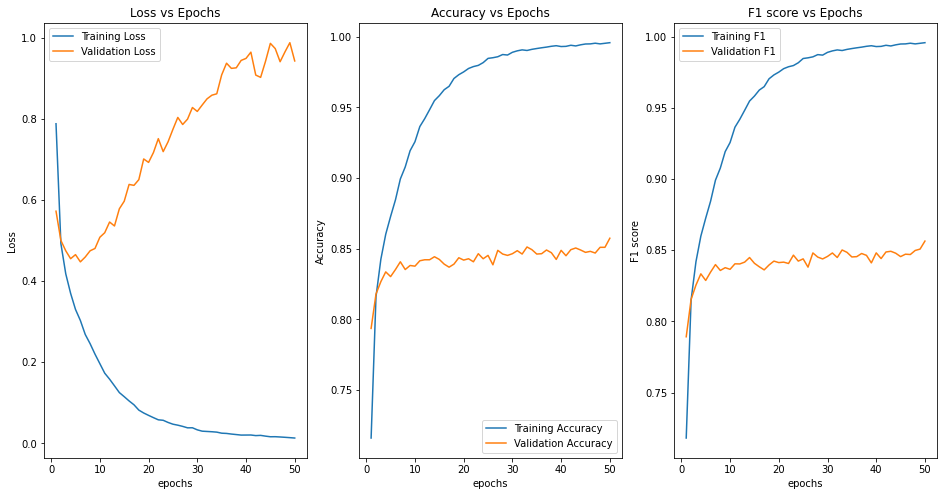

Loading model at epoch 50 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 1.0550 Accuracy: 0.8479 F1_score: 0.8475
Result on unlabelled test set: Loss: 18.0866 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 6.1419 Accuracy: 0.5935 F1_score: 0.5117


In [5]:
mode_metric = whole_flow(6, True)

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7735 Accuracy: 0.7237 F1_score: 0.7228
	Validation - Loss: 0.5298 Accuracy: 0.8038 F1_score: 0.8015
Epoch: 2
	Train      - Loss: 0.4641 Accuracy: 0.8311 F1_score: 0.8303
	Validation - Loss: 0.4424 Accuracy: 0.8423 F1_score: 0.8418
Epoch: 3
	Train      - Loss: 0.3894 Accuracy: 0.8571 F1_score: 0.8566
	Validation - Loss: 0.4128 Accuracy: 0.8543 F1_score: 0.8540
Epoch: 4
	Train      - Loss: 0.3357 Accuracy: 0.8769 F1_score: 0.8766
	Validation - Loss: 0.4006 Accuracy: 0.8600 F1_score: 0.8600
Epoch: 5
	Train      - Loss: 0.3032 Accuracy: 0.8877 F1_score: 0.8874
	Validation - Loss: 0.3898 Accuracy: 0.8638 F1_score: 0.8626
Epoch: 6
	Train      - Loss: 0.2739 Accuracy: 0.9008 F1_score: 0.9006
	Validation - Loss: 0.3850 Accuracy: 0.8677 F1_score: 0.8676
Epoch: 7
	Train      - Loss: 0.2450 Accuracy: 0.9105 F1_score: 0.9104
	Validation - Loss: 0.3760 Accuracy: 0.869

<Figure size 432x288 with 0 Axes>

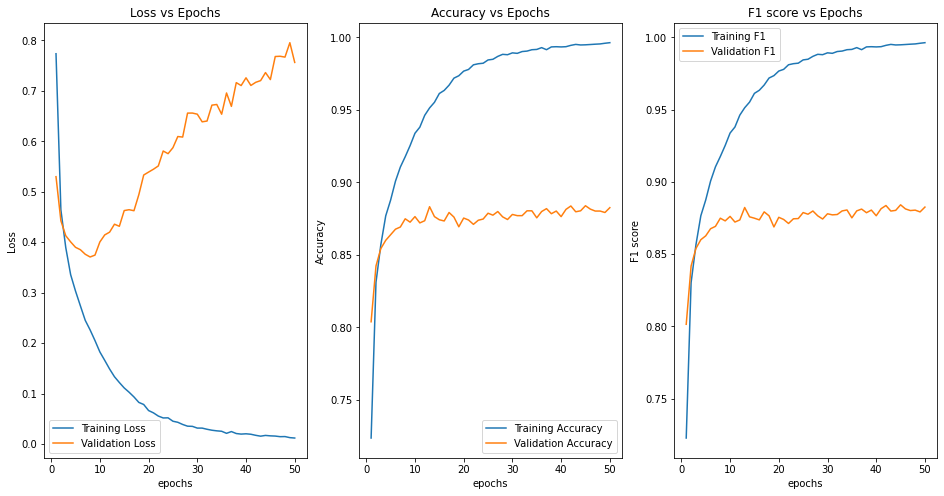

Loading model at epoch 45 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 1.0789 Accuracy: 0.8403 F1_score: 0.8455
Result on unlabelled test set: Loss: 0.2756 Accuracy: 0.9563 F1_score: 0.9647
Result on full test set      : Loss: 0.8350 Accuracy: 0.8751 F1_score: 0.8753


In [6]:
mode_metric = whole_flow(7, True)

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8801111111111111
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7301 Accuracy: 0.7483 F1_score: 0.7470
	Validation - Loss: 0.5293 Accuracy: 0.8120 F1_score: 0.8091
Epoch: 2
	Train      - Loss: 0.4365 Accuracy: 0.8424 F1_score: 0.8416
	Validation - Loss: 0.4407 Accuracy: 0.8393 F1_score: 0.8391
Epoch: 3
	Train      - Loss: 0.3670 Accuracy: 0.8646 F1_score: 0.8641
	Validation - Loss: 0.4050 Accuracy: 0.8507 F1_score: 0.8499
Epoch: 4
	Train      - Loss: 0.3224 Accuracy: 0.8812 F1_score: 0.8808
	Validation - Loss: 0.3850 Accuracy: 0.8620 F1_score: 0.8616
Epoch: 5
	Train      - Loss: 0.2889 Accuracy: 0.8929 F1_score: 0.8926
	Validation - Loss: 0.3754 Accuracy: 0.8648 F1_score: 0.8634
Epoch: 6
	Train      - Loss: 0.2631 Accuracy: 0.9018 F1_score: 0.9016
	Validation - Loss: 0.3837 Accuracy: 0.8638 F1_score: 0.8633
Epoch: 7
	Train      - Loss: 0.2405 Accuracy: 0.9106 F

<Figure size 432x288 with 0 Axes>

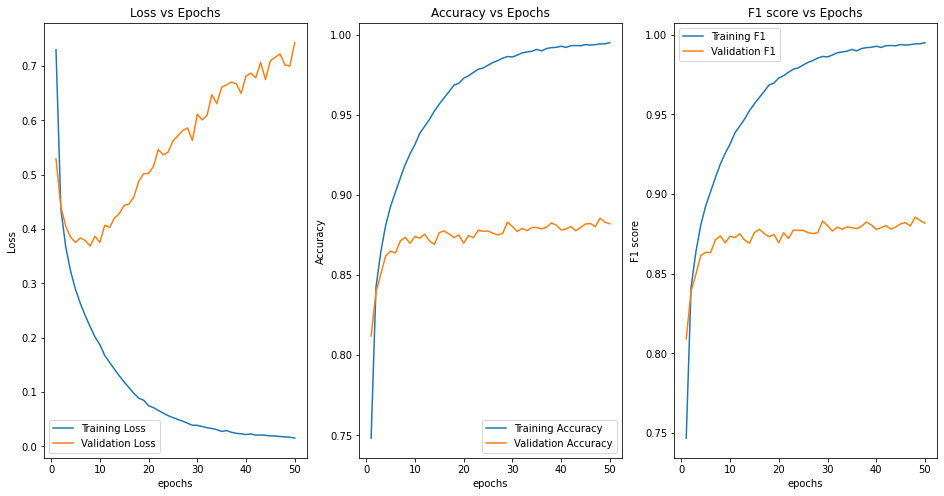

Loading model at epoch 48 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.9776 Accuracy: 0.8470 F1_score: 0.8505
Result on unlabelled test set: Loss: 1.4933 Accuracy: 0.8707 F1_score: 0.8818
Result on full test set      : Loss: 1.1424 Accuracy: 0.8541 F1_score: 0.8546


In [7]:
mode_metric = whole_flow(0, True)

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.8813888888888889
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7221 Accuracy: 0.7477 F1_score: 0.7474
	Validation - Loss: 0.5430 Accuracy: 0.8067 F1_score: 0.8039
Epoch: 2
	Train      - Loss: 0.4438 Accuracy: 0.8397 F1_score: 0.8385
	Validation - Loss: 0.4618 Accuracy: 0.8343 F1_score: 0.8316
Epoch: 3
	Train      - Loss: 0.3727 Accuracy: 0.8640 F1_score: 0.8635
	Validation - Loss: 0.4254 Accuracy: 0.8503 F1_score: 0.8492
Epoch: 4
	Train      - Loss: 0.3283 Accuracy: 0.8795 F1_score: 0.8791
	Validation - Loss: 0.4142 Accuracy: 0.8533 F1_score: 0.8529
Epoch: 5
	Train      - Loss: 0.2958 Accuracy: 0.8911 F1_score: 0.8908
	Validation - Loss: 0.4057 Accuracy: 0.8600 F1_score: 0.8576
Epoch: 6
	Train      - Loss: 0.2649 Accuracy: 0.9014 F1_score: 0.9011
	Validation - Loss: 0.3950 Accuracy: 0.8657 F1_score: 0.8651
Epoch: 7
	Train      - Loss: 0.2442 Accuracy:

<Figure size 432x288 with 0 Axes>

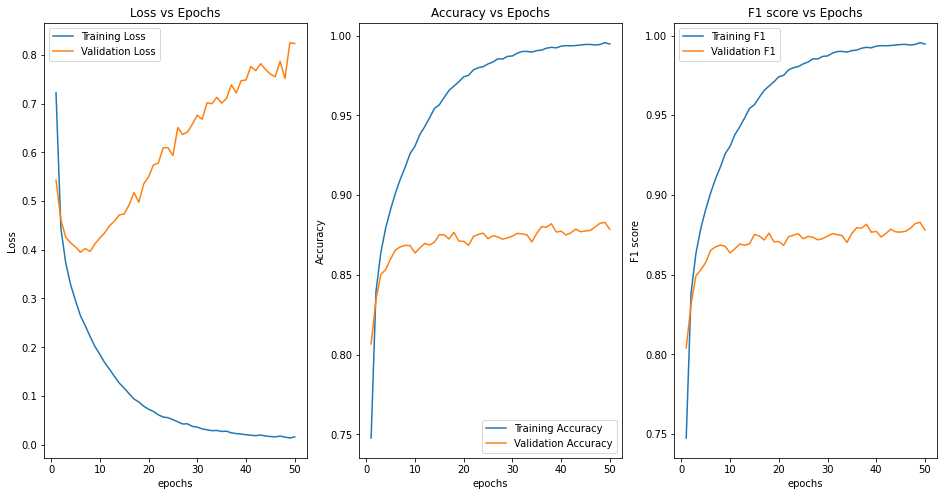

Loading model at epoch 49 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 1.0286 Accuracy: 0.8420 F1_score: 0.8467
Result on unlabelled test set: Loss: 1.2566 Accuracy: 0.8740 F1_score: 0.8848
Result on full test set      : Loss: 1.0910 Accuracy: 0.8516 F1_score: 0.8522


In [8]:
mode_metric = whole_flow(1, True)

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

In [9]:
mode_metric = whole_flow(2, True)

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': nan}
Epoch: 2 Loss: {'loss': nan}
Epoch: 3 Loss: {'loss': nan}
Epoch: 4 Loss: {'loss': nan}
Epoch: 5 Loss: {'loss': nan}
Epoch: 6 Loss: {'loss': nan}
Epoch: 7 Loss: {'loss': nan}
Epoch: 8 Loss: {'loss': nan}
Epoch: 9 Loss: {'loss': nan}
Epoch: 10 Loss: {'loss': nan}
Epoch: 11 Loss: {'loss': nan}
Epoch: 12 Loss: {'loss': nan}
Epoch: 13 Loss: {'loss': nan}
Epoch: 14 Loss: {'loss': nan}
Epoch: 15 Loss: {'loss': nan}


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8328888888888889
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7631 Accuracy: 0.7289 F1_score: 0.7270
	Validation - Loss: 0.5154 Accuracy: 0.8128 F1_score: 0.8105
Epoch: 2
	Train      - Loss: 0.4565 Accuracy: 0.8334 F1_score: 0.8327
	Validation - Loss: 0.4320 Accuracy: 0.8472 F1_score: 0.8473
Epoch: 3
	Train      - Loss: 0.3826 Accuracy: 0.8614 F1_score: 0.8610
	Validation - Loss: 0.4071 Accuracy: 0.8553 F1_score: 0.8544
Epoch: 4
	Train      - Loss: 0.3368 Accuracy: 0.8773 F1_score: 0.8770
	Validation - Loss: 0.3874 Accuracy: 0.8650 F1_score: 0.8649
Epoch: 5
	Train      - Loss: 0.2992 Accuracy: 0.8904 F1_score: 0.8902
	Validation - Loss: 0.3921 Accuracy: 0.8618 F1_score: 0.8600
Epoch: 6
	Train      - Loss: 0.2712 Accuracy: 0.9019 F1_score: 0.9016
	Validation - Loss: 0.3823 Accuracy: 0.8678 F1_score: 0.8671
Epoch: 7
	Train      - Loss: 0.2485 Accuracy

<Figure size 432x288 with 0 Axes>

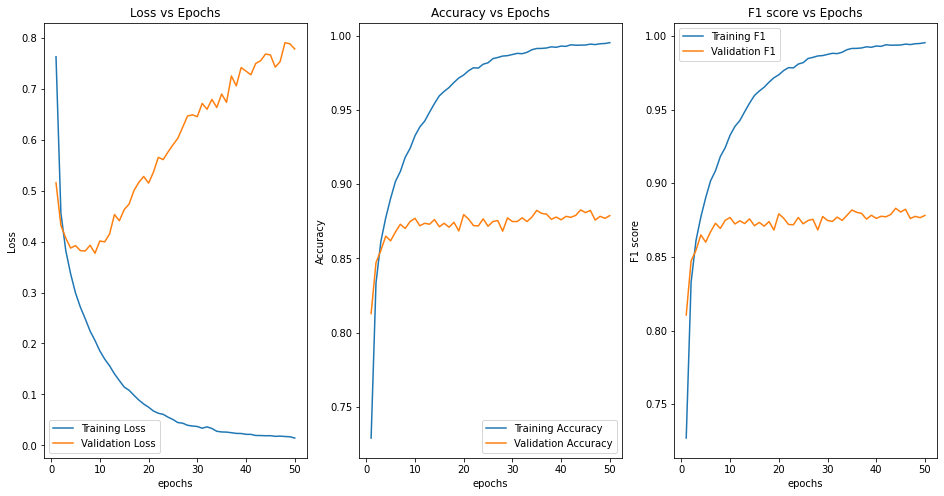

Loading model at epoch 44 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 1.0291 Accuracy: 0.8490 F1_score: 0.8523
Result on unlabelled test set: Loss: 2.1482 Accuracy: 0.8207 F1_score: 0.8267
Result on full test set      : Loss: 1.3665 Accuracy: 0.8405 F1_score: 0.8395


In [10]:
mode_metric = whole_flow(3, True)

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.6935555555555556
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7716 Accuracy: 0.7293 F1_score: 0.7287
	Validation - Loss: 0.5273 Accuracy: 0.8080 F1_score: 0.8076
Epoch: 2
	Train      - Loss: 0.4668 Accuracy: 0.8294 F1_score: 0.8286
	Validation - Loss: 0.4536 Accuracy: 0.8380 F1_score: 0.8370
Epoch: 3
	Train      - Loss: 0.3908 Accuracy: 0.8570 F1_score: 0.8565
	Validation - Loss: 0.4065 Accuracy: 0.8543 F1_score: 0.8545
Epoch: 4
	Train      - Loss: 0.3448 Accuracy: 0.8732 F1_score: 0.8728
	Validation - Loss: 0.3969 Accuracy: 0.8572 F1_score: 0.8552
Epoch: 5
	Train      - Loss: 0.3125 Accuracy: 0.8834 F1_score: 0.8830
	Validation - Loss: 0.3898 Accuracy: 0.8570 F1_score: 0.8555
Epoch: 6
	Train      - Loss: 0.2828 Accuracy: 0.8945 F1_score: 0.8943
	Validation - Loss: 0.3723 Accuracy: 0.8697 F1_score: 0.8687
Epoch: 7
	Train      - Loss: 0.2570

<Figure size 432x288 with 0 Axes>

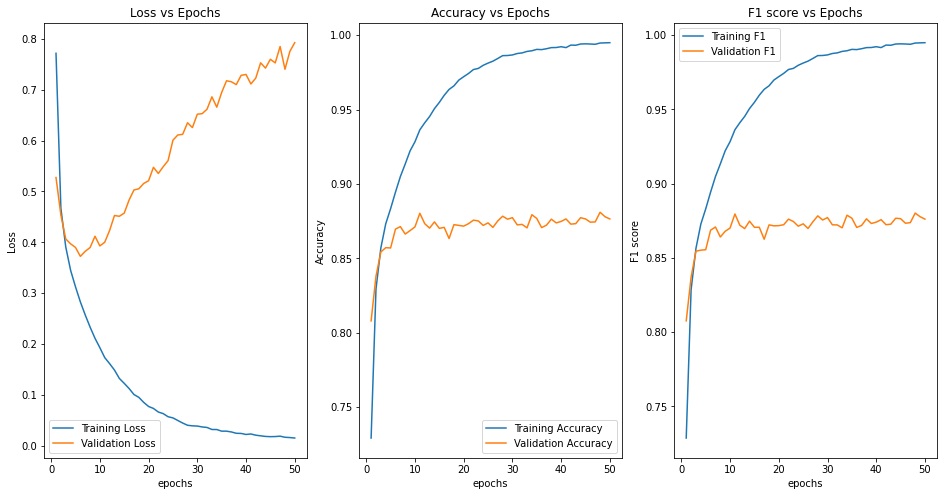

Loading model at epoch 48 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 1.0739 Accuracy: 0.8383 F1_score: 0.8436
Result on unlabelled test set: Loss: 4.5953 Accuracy: 0.6860 F1_score: 0.6754
Result on full test set      : Loss: 2.1374 Accuracy: 0.7926 F1_score: 0.7880


In [11]:
mode_metric = whole_flow(4, True)

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

In [12]:
mode_metric = whole_flow(5, True)

Getting train and validate dataloaders for mode 5: clustering: Gaussian Mixture with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': nan}
Epoch: 2 Loss: {'loss': nan}
Epoch: 3 Loss: {'loss': nan}
Epoch: 4 Loss: {'loss': nan}
Epoch: 5 Loss: {'loss': nan}
Epoch: 6 Loss: {'loss': nan}
Epoch: 7 Loss: {'loss': nan}
Epoch: 8 Loss: {'loss': nan}
Epoch: 9 Loss: {'loss': nan}
Epoch: 10 Loss: {'loss': nan}
Epoch: 11 Loss: {'loss': nan}
Epoch: 12 Loss: {'loss': nan}
Epoch: 13 Loss: {'loss': nan}
Epoch: 14 Loss: {'loss': nan}
Epoch: 15 Loss: {'loss': nan}


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

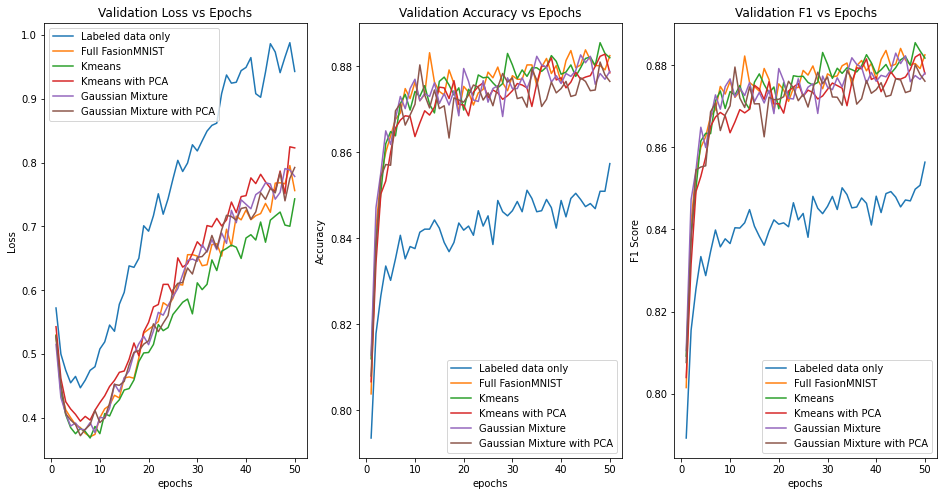

In [13]:
report_summary(mode_metrics, mode_description_short)

## Conclusion